In [ ]:
from multiprocessing.sharedctypes import Value
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy import linalg

gamma = 1.4 


def U_conserved_variable(V):
    u_1 = V[0] 
    u_2 = V[0] * V[1] # x 축
    u_3 = V[0] * V[2] # y 축
    u_4 = V[0] * V[3] # y 축
    kinematics = 0.5*V[0]*(V[1]**2+V[2]**2+V[3]**2)
    u_5 = V[4]/(gamma-1) + kinematics  # using ideal gas
    return np.array([u_1, u_2, u_3, u_4, u_5])


def V_primitive_variable(U):
    rho = U[0]
    vx  = U[1] / rho
    vy  = U[2] / rho
    vz  = U[3] / rho
    p   = (gamma-1)*(U[4] - 0.5*rho*(vx**2 + vy**2 + vz**2))
    return np.array([rho, vx, vy, vz, p])


def outgoing(V, nx, ng):
    V[:, :ng] = V[:, ng:ng+1]
    V[:, nx+ng:] = V[:, nx+ng-1:nx+ng]
    return V


def Flux(V):
    rho, vx,vy,vz,p = V
    F = np.zeros(5)
    F[0] = rho*vx
    F[1] = rho*vx*vx + p
    F[2] = rho*vx*vy
    F[3] = rho*vx*vz
    kinematics = 0.5*rho*(vx**2+vy**2+vz**2)
    E = p/(gamma-1) + kinematics
    F[4] = (E + p)*vx # (U[4] + p) * u U[4] = E 
    return F


def MC_RM(a,b,c): # the precise linear MC reconstruction method
    sign_a = np.sign(a) # -1 , 0 , 1 
    sign_b = np.sign(b) 
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a +sign_b)*min(abs(a),abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i +sign_c)*min(abs(s_i),abs(c))
    return   s_f 


def reconstruct_V(V,nx,ng):
    N = V.shape[1]
    VL = np.zeros((5, N))
    VR = np.zeros((5, N))

    dV = np.zeros((5, N)) #slope
    for k in range(5):
        for i in range(ng, nx+ng):
            a = (V[k, i]   - V[k, i-1]) 
            b = (V[k, i+1] - V[k, i])  
            c = (V[k, i+1] - V[k, i-1]) *0.5
            dV[k, i] = MC_RM(a, b, c)

    # interface states
    for k in range(5):
        for i in range(ng-1, nx+ng):  
            VL[k, i] = V[k, i] - 0.5*dV[k, i]
            VR[k, i] = V[k, i] + 0.5*dV[k, i]

    return VL, VR



x_min, x_max, nx = -1,1,400
dx = (x_max-x_min) / (nx)
x0 = 0.0  # discontinuum region 
ng= 2 
N = nx + 2*ng

x = np.zeros(N)
for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx


v = 1.0
lam= 0.5
dt = lam*(dx/v)

Time = 0.0
Time_set = 0.2

rho_L, ux_L,uy_L,uz_L, P_L = 1.0, 0.0, 0.0, 0.0, 1.0
rho_R, ux_R,uy_R,uz_R,P_R = 0.125, 0.0, 0.0, 0.0, 0.1

F = np.zeros((5, N+1))  # interface flux


# Step 1 : Define U,V + B.C  -------------------------------------------------

V = np.zeros((5, N))
for i in range(N):
    if x[i] < x0:  # x0 is initial discontinuum point
        V[:, i] = [rho_L, ux_L, uy_L, uz_L, P_L]  # Region 1
    else: 
        V[:, i] = [rho_R, ux_R, uy_R, uz_R, P_R] # Region 5



U = U_conserved_variable(V)
V = outgoing(V, nx, ng)


# # Step 2 : Reconstruction  -------------------------------------------------


VL, VR = reconstruct_V(V,nx,ng)
UL, UR = U_conserved_variable(VL), U_conserved_variable(VR) 

for i in range(ng-1,nx+ng):

    vxL, pL, rhoL = VL[0,i], VL[4,i], VL[0,i]
    vxR, pR, rhoR = VR[1,i], VR[4,i], VR[0,i]

    cL = np.sqrt(gamma*pL/rhoL)
    cR = np.sqrt(gamma*pR/rhoR)

    SL = min(vxL - cL, vxR - cR)
    SR = max(vxL + cL, vxR + cR)

    FL = Flux(VL[:,i])
    FR = Flux(VR[:,i])

    # print(FR)
    if SL >= 0 :
        F[:,i] = FL 
    elif SR <= 0 :
        F[:,i] = FR 
    else :
        F[:,i] = (SR*FL - SL*FR + SL*SR*(UR[:,i]-UL[:,i]))/(SR-SL)

F

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
from multiprocessing.sharedctypes import Value
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy import linalg

gamma = 1.4 


def U_conserved_variable(V):
    rho = V[0]
    vx, vy, vz = V[1], V[2], V[3]
    p = V[4]
    kin = 0.5*rho*(vx**2 + vy**2 + vz**2)
    E = p/(gamma-1) + kin
    return np.array([rho, rho*vx, rho*vy, rho*vz, E])


def V_primitive_variable(U):
    rho = U[0]
    vx  = U[1] / rho
    vy  = U[2] / rho
    vz  = U[3] / rho
    p   = (gamma-1)*(U[4] - 0.5*rho*(vx**2 + vy**2 + vz**2))
    return np.array([rho, vx, vy, vz, p])


def outgoing(V, nx, ng):
    V[:, :ng] = V[:, ng:ng+1]
    V[:, nx+ng:] = V[:, nx+ng-1:nx+ng]
    return V


def Flux(V):
    rho, vx,vy,vz,p = V
    F = np.zeros(5)
    F[0] = rho*vx
    F[1] = rho*vx*vx + p
    F[2] = rho*vx*vy
    F[3] = rho*vx*vz
    kinematics = 0.5*rho*(vx**2+vy**2+vz**2)
    E = p/(gamma-1) + kinematics
    F[4] = (E + p)*vx # (U[4] + p) * u U[4] = E 
    return F


def MC_RM(a,b,c): # the precise linear MC reconstruction method
    sign_a = np.sign(a) # -1 , 0 , 1 
    sign_b = np.sign(b) 
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a +sign_b)*min(abs(a),abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i +sign_c)*min(abs(s_i),abs(c))
    return   s_f 


def reconstruct_V(V,nx,ng):
    N = V.shape[1]
    VL = np.zeros((5, N))
    VR = np.zeros((5, N))

    dV = np.zeros((5, N)) #slope
    for k in range(5):
        for i in range(ng, nx+ng):
            a = (V[k, i]   - V[k, i-1]) 
            b = (V[k, i+1] - V[k, i])  
            c = (V[k, i+1] - V[k, i-1]) *0.5
            dV[k, i] = MC_RM(a, b, c)

    # interface states
    for k in range(5):
        for i in range(ng-1, nx+ng):  
            VL[k, i] = V[k, i] - 0.5*dV[k, i]
            VR[k, i] = V[k, i+1] - 0.5*dV[k, i+1]

    return VL, VR


def HLL_Method(U,V,nx,ng,dx,dt):
    N = V.shape[1]
    V = outgoing(V, nx, ng)
    V_L, V_R = reconstruct_V(V,nx,ng)
    F = np.zeros((5, N+1))  # interface flux

    for i in range(ng-1,nx+ng):
        VL = V_L[:, i]
        VR = V_R[:, i]

        rhoL, vxL, vyL, vzL, pL = VL
        rhoR, vxR, vyR, vzR, pR = VR


        UL = U_conserved_variable(VL)
        UR = U_conserved_variable(VR)


        cL = np.sqrt(gamma*pL/rhoL)
        cR = np.sqrt(gamma*pR/rhoR)

        EL = UL[4] 
        ER = UR[4]

        HL = (EL + pL) / rhoL
        HR = (ER + pR) / rhoR
        srL = np.sqrt(rhoL); srR = np.sqrt(rhoR)
        denom = srL + srR
        roe_V = (srL*vxL + srR*vxR) / denom
        roe_H = (srL*HL  + srR*HR ) / denom
        tmp = (gamma-1.0) * (roe_H - 0.5*roe_V**2)
        roe_a = np.sqrt(max(tmp, 0.0))
        SL = min(vxL - cL, vxR - cR, roe_V - roe_a)
        SR = max(vxL + cL, vxR + cR, roe_V + roe_a)

        FL = Flux(VL)
        FR = Flux(VR)


        if SL >= 0 :
            F[:,i] = FL 
        elif SR <= 0 :
            F[:,i] = FR 
        else :
            F[:,i] = (SR*FL - SL*FR + SL*SR*(UR-UL))/(SR-SL)

    U_new = U.copy()

    for i in range(ng, nx+ng):
        U_new[:, i] = U[:, i] - (dt/dx) * (F[:, i] - F[:, i-1])
        
    return U_new


x_min, x_max, nx = -1,1,400
dx = (x_max-x_min) / (nx)
x0 = 0.0  # discontinuum region 
ng= 2 
N = nx + 2*ng

x = np.zeros(N)
for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx


v = 1.0
lam= 0.5
dt = lam*(dx/v)

Time = 0.0
Time_set = 0.2

rho_L, ux_L,uy_L,uz_L, P_L = 1.0, 0.0, 0.0, 0.0, 1.0
rho_R, ux_R,uy_R,uz_R,P_R = 0.125, 0.0, 0.0, 0.0, 0.1




# Step 1 : Define U,V + B.C -------------------------------------------------

V = np.zeros((5, N))
for i in range(N):
    if x[i] < x0:  # x0 is initial discontinuum point
        V[:, i] = [rho_L, ux_L, uy_L, uz_L, P_L]  # Region 1
    else: 
        V[:, i] = [rho_R, ux_R, uy_R, uz_R, P_R] # Region 5
# U = U_conserved_variable(V)

# Step 2 - HLL
while Time <= Time_set :
    V = outgoing(V, nx, ng)
    c = np.sqrt(gamma * V[4, ng:nx+ng] / V[0, ng:nx+ng])
    umax = np.max(np.abs(V[1, ng:nx+ng]) + c)
    dt = lam * dx / umax

    if Time + dt > Time_set:
        dt = Time_set - Time

    U = U_conserved_variable(V)

    U = HLL_Method(U,V,nx,ng,dx,dt)

    V = V_primitive_variable(U)

    Time += dt



KeyboardInterrupt: 

In [31]:
V = np.array([1,2,3,4,5])
U = np.zeros((5,20))

U.ndim

2

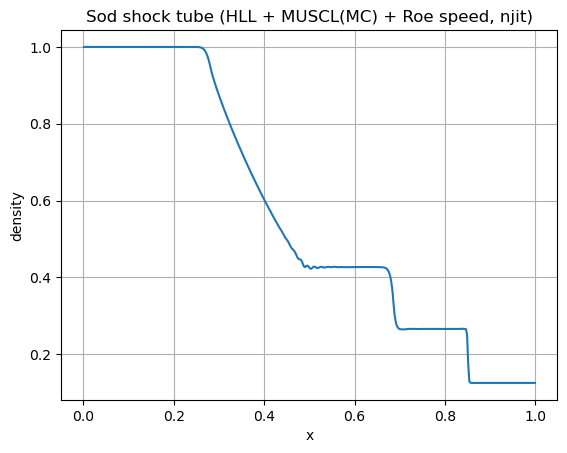

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

gamma = 1.4

@njit
def MC_RM(a, b, c):
    sign_a = np.sign(a)
    sign_b = np.sign(b)
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a + sign_b) * min(abs(a), abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i + sign_c) * min(abs(s_i), abs(c))
    return s_f


#numa 안정성
@njit
def U_conserved_1d(V):
    rho = V[0]
    vx  = V[1]
    vy  = V[2]
    vz  = V[3]
    p   = V[4]
    E = p/(gamma-1.0) + 0.5*rho*(vx*vx + vy*vy + vz*vz)
    U = np.zeros(5)
    U[0] = rho
    U[1] = rho*vx
    U[2] = rho*vy
    U[3] = rho*vz
    U[4] = E
    return U

@njit
def U_conserved_2d(V):
    N = V.shape[1]
    U = np.zeros((5, N))
    for i in range(N):
        rho = V[0, i]
        vx  = V[1, i]
        vy  = V[2, i]
        vz  = V[3, i]
        p   = V[4, i]
        E = p/(gamma-1.0) + 0.5*rho*(vx*vx + vy*vy + vz*vz)

        U[0, i] = rho
        U[1, i] = rho*vx
        U[2, i] = rho*vy
        U[3, i] = rho*vz
        U[4, i] = E
    return U

@njit
def V_primitive(U):
    N = U.shape[1]
    V = np.zeros((5, N))
    for i in range(N):
        rho = U[0, i]
        vx  = U[1, i] / rho
        vy  = U[2, i] / rho
        vz  = U[3, i] / rho
        p   = (gamma-1.0) * (U[4, i] - 0.5*rho*(vx*vx + vy*vy + vz*vz))

        V[0, i] = rho
        V[1, i] = vx
        V[2, i] = vy
        V[3, i] = vz
        V[4, i] = p
    return V


@njit
def outgoing(V, nx, ng):
    V[:, :ng] = V[:, ng:ng+1]
    V[:, nx+ng:] = V[:, nx+ng-1:nx+ng]
    return V

@njit
def Flux(V):
    rho = V[0]
    vx  = V[1]
    vy  = V[2]
    vz  = V[3]
    p   = V[4]

    F = np.zeros(5)
    F[0] = rho*vx
    F[1] = rho*vx*vx + p
    F[2] = rho*vx*vy
    F[3] = rho*vx*vz
    E = p/(gamma-1.0) + 0.5*rho*(vx*vx + vy*vy + vz*vz)
    F[4] = (E + p) * vx
    return F
    
@njit
def reconstruct_V(V, nx, ng):
    N = V.shape[1]
    V_L = np.zeros((5, N))
    V_R = np.zeros((5, N))
    dV  = np.zeros((5, N))

    for k in range(5):
        for i in range(ng, nx+ng):
            a = V[k, i]   - V[k, i-1]
            b = 0.5 * (V[k, i+1] - V[k, i-1])
            c = V[k, i+1] - V[k, i]
            dV[k, i] = MC_RM(a, b, c)

    for k in range(5):
        for i in range(ng-1, nx+ng):   # interface i+1/2
            V_L[k, i] = V[k, i]   + 0.5*dV[k, i]
            V_R[k, i] = V[k, i+1] - 0.5*dV[k, i+1]

    return V_L, V_R

@njit
def HLL_Method(U, V, nx, ng, dx, dt):
    N = V.shape[1]
    V = outgoing(V, nx, ng)
    V_L, V_R = reconstruct_V(V, nx, ng)
    F = np.zeros((5, N))  
    for i in range(ng-1, nx+ng):
        VL = V_L[:, i].copy()
        VR = V_R[:, i].copy()
        
        rhoL, vxL, vyL, vzL, pL = VL
        rhoR, vxR, vyR, vzR, pR = VR

        UL = U_conserved_1d(VL)
        UR = U_conserved_1d(VR)

        cL = np.sqrt(gamma * pL / rhoL)
        cR = np.sqrt(gamma * pR / rhoR)

        EL = UL[4]
        ER = UR[4]
        HL = (EL + pL) / rhoL
        HR = (ER + pR) / rhoR

        srL = np.sqrt(rhoL)
        srR = np.sqrt(rhoR)
        denom = srL + srR

        roe_V = (srL*vxL + srR*vxR) / denom
        roe_H = (srL*HL  + srR*HR ) / denom
        tmp = (gamma-1.0) * (roe_H - 0.5*roe_V*roe_V)
        if tmp < 0.0:
            tmp = 0.0
        roe_a = np.sqrt(tmp)

        SL = min(vxL - cL, vxR - cR, roe_V - roe_a)
        SR = max(vxL + cL, vxR + cR, roe_V + roe_a)

        FL = Flux(VL)
        FR = Flux(VR)

        if SL >= 0.0:
            F[:, i] = FL
        elif SR <= 0.0:
            F[:, i] = FR
        else:
            F[:, i] = (SR*FL - SL*FR + SL*SR*(UR - UL)) / (SR - SL)

    U_new = U.copy()

    for j in range(ng, nx+ng):
        U_new[:, j] = U[:, j] - dt/dx * (F[:, j] - F[:, j-1])

    return U_new

    # ------------------- Run -------------------
x_min, x_max, nx = 0.0, 1.0, 400
dx = (x_max-x_min) / nx
x0 = 0.5
ng = 2
N = nx + 2*ng

x = np.zeros(N)
for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx

lam = 0.5
Time = 0.0
Time_set = 0.2

rho_L, ux_L, uy_L, uz_L, P_L = 1.0,   0.0, 0.0, 0.0, 1.0
rho_R, ux_R, uy_R, uz_R, P_R = 0.125, 0.0, 0.0, 0.0, 0.1

V = np.zeros((5, N))
for i in range(N):
    if x[i] < x0:
        V[:, i] = [rho_L, ux_L, uy_L, uz_L, P_L]
    else:
        V[:, i] = [rho_R, ux_R, uy_R, uz_R, P_R]

while Time < Time_set:
    V = outgoing(V, nx, ng)
    c = np.sqrt(gamma * V[4, ng:nx+ng] / V[0, ng:nx+ng])
    umax = np.max(np.abs(V[1, ng:nx+ng]) + c)
    dt = lam * dx / umax

    if Time + dt > Time_set:
        dt = Time_set - Time

    U =U_conserved_2d(V)
    U = HLL_Method(U, V, nx, ng, dx, dt)
    V = V_primitive(U)

    Time += dt

# Plot
xp = x[ng:nx+ng]
rho = V[0, ng:nx+ng]
u   = V[1, ng:nx+ng]
p   = V[4, ng:nx+ng]

plt.figure()
plt.plot(xp, rho)
plt.xlabel("x"); plt.ylabel("density")
plt.title("Sod shock tube (HLL + MUSCL(MC) + Roe speed, njit)")
plt.grid(True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

gamma = 1.4
EPS = 1e-12

# ---------------------------
# 2D (5,N) 변환 함수들: numba 안정
# ---------------------------


@njit
def U_from_V_2d(V):
    N = V.shape[1]
    U = np.zeros((5, N))
    for i in range(N):
        rho = V[0, i]
        vx  = V[1, i]
        vy  = V[2, i]
        vz  = V[3, i]
        p   = V[4, i]
        # if rho < EPS: rho = EPS
        # if p   < EPS: p   = EPS
        E = p/(gamma-1.0) + 0.5*rho*(vx*vx + vy*vy + vz*vz)

        U[0, i] = rho
        U[1, i] = rho*vx
        U[2, i] = rho*vy
        U[3, i] = rho*vz
        U[4, i] = E
    return U

@njit
def V_from_U_2d(U):
    N = U.shape[1]
    V = np.zeros((5, N))
    for i in range(N):
        rho = U[0, i]
        # if rho < EPS: rho = EPS
        inv = 1.0 / rho
        vx  = U[1, i] * inv
        vy  = U[2, i] * inv
        vz  = U[3, i] * inv
        p   = (gamma-1.0) * (U[4, i] - 0.5*rho*(vx*vx + vy*vy + vz*vz))
        # if p < EPS: p = EPS

        V[0, i] = rho
        V[1, i] = vx
        V[2, i] = vy
        V[3, i] = vz
        V[4, i] = p
    return V
@njit
def U_conserved_variable(V):
    if V.ndim == 1:
        rho = V[0]
        vx  = V[1]
        vy  = V[2]
        vz  = V[3]
        p   = V[4]
        E = p/(gamma-1.0) + 0.5*rho*(vx*vx + vy*vy + vz*vz)
        U[0] = rho
        U[1] = rho*vx
        U[2] = rho*vy
        U[3] = rho*vz
        U[4] = E
    else:
        N = V.shape[1]
        for i in range(N):
            rho = V[0, i]
            vx  = V[1, i]
            vy  = V[2, i]
            vz  = V[3, i]
            p   = V[4, i]
            E = p/(gamma-1.0) + 0.5*rho*(vx*vx + vy*vy + vz*vz)
            U[0, i] = rho
            U[1, i] = rho*vx
            U[2, i] = rho*vy
            U[3, i] = rho*vz
            U[4, i] = E
    return U

@njit
def U_from_V_1d(V):
    rho = V[0]
    vx  = V[1]
    vy  = V[2]
    vz  = V[3]
    p   = V[4]
    # if rho < EPS: rho = EPS
    # if p   < EPS: p   = EPS
    E = p/(gamma-1.0) + 0.5*rho*(vx*vx + vy*vy + vz*vz)
    U = np.zeros(5)
    U[0] = rho
    U[1] = rho*vx
    U[2] = rho*vy
    U[3] = rho*vz
    U[4] = E
    return U

@njit
def outgoing(V, nx, ng):
    V[:, :ng] = V[:, ng:ng+1]
    V[:, nx+ng:] = V[:, nx+ng-1:nx+ng]
    return V

# def outgoing(V, nx, ng):
#     N = V.shape[1]
#     for k in range(5):
#         leftv = V[k, ng]
#         for i in range(ng):
#             V[k, i] = leftv
#         rightv = V[k, nx+ng-1]
#         for i in range(nx+ng, N):
#             V[k, i] = rightv
#     return V

@njit
def Flux(V):
    rho = V[0]
    vx  = V[1]
    vy  = V[2]
    vz  = V[3]
    p   = V[4]
    # if rho < EPS: rho = EPS
    # if p   < EPS: p   = EPS

    F = np.zeros(5)
    F[0] = rho*vx
    F[1] = rho*vx*vx + p
    F[2] = rho*vx*vy
    F[3] = rho*vx*vz
    E = p/(gamma-1.0) + 0.5*rho*(vx*vx + vy*vy + vz*vz)
    F[4] = (E + p) * vx
    return F

@njit
def MC_RM(a, b, c):
    sign_a = np.sign(a)
    sign_b = np.sign(b)
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a + sign_b) * min(abs(a), abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i + sign_c) * min(abs(s_i), abs(c))
    return s_f

@njit
def reconstruct_V(V, nx, ng):

    N = V.shape[1]
    V_L = np.zeros((5, N))
    V_R = np.zeros((5, N))
    dV  = np.zeros((5, N))

    for k in range(5):
        for i in range(ng, nx+ng):
            a = V[k, i]   - V[k, i-1]
            b = 0.5 * (V[k, i+1] - V[k, i-1])
            c = V[k, i+1] - V[k, i]
            dV[k, i] = MC_RM(a, b, c)

    for k in range(5):
        for i in range(ng-1, nx+ng):   # interface i+1/2
            V_L[k, i] = V[k, i]   + 0.5*dV[k, i]
            V_R[k, i] = V[k, i+1] - 0.5*dV[k, i+1]

    return V_L, V_R

@njit
def HLL_Method(U, V, nx, ng, dx, dt):
    N = V.shape[1]
    V = outgoing(V, nx, ng)

    V_L, V_R = reconstruct_V(V, nx, ng)
    F = np.zeros((5, N))  # interface flux at column i (i=ng-1..nx+ng-1)

    for i in range(ng-1, nx+ng):
        VL = V_L[:, i].copy()
        VR = V_R[:, i].copy()
        
        rhoL, vxL, vyL, vzL, pL = VL
        rhoR, vxR, vyR, vzR, pR = VR

        UL = U_conserved_variable(VL)
        UR = U_conserved_variable(VR)

        cL = np.sqrt(gamma * pL / rhoL)
        cR = np.sqrt(gamma * pR / rhoR)

        # Roe-augmented wave speeds (네가 쓰던 방식)
        EL = UL[4]
        ER = UR[4]
        HL = (EL + pL) / rhoL
        HR = (ER + pR) / rhoR

        srL = np.sqrt(rhoL)
        srR = np.sqrt(rhoR)
        denom = srL + srR
        # if denom < EPS:
        #     denom = EPS

        roe_V = (srL*vxL + srR*vxR) / denom
        roe_H = (srL*HL  + srR*HR ) / denom
        tmp = (gamma-1.0) * (roe_H - 0.5*roe_V*roe_V)
        if tmp < 0.0:
            tmp = 0.0
        roe_a = np.sqrt(tmp)

        SL = min(vxL - cL, vxR - cR, roe_V - roe_a)
        SR = max(vxL + cL, vxR + cR, roe_V + roe_a)

        FL = Flux(VL)
        FR = Flux(VR)

        if SL >= 0.0:
            F[:, i] = FL
        elif SR <= 0.0:
            F[:, i] = FR
        else:
            F[:, i] = (SR*FL - SL*FR + SL*SR*(UR - UL)) / (SR - SL)

    U_new = U.copy()
    coef = dt/dx
    for j in range(ng, nx+ng):
        U_new[:, j] = U[:, j] - coef * (F[:, j] - F[:, j-1])

    return U_new


# ------------------- Run -------------------
x_min, x_max, nx = -1.0, 1.0, 400
dx = (x_max-x_min) / nx
x0 = 0.0
ng = 2
N = nx + 2*ng

x = np.zeros(N)
for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx

lam = 0.5
Time = 0.0
Time_set = 0.2

rho_L, ux_L, uy_L, uz_L, P_L = 1.0,   0.0, 0.0, 0.0, 1.0
rho_R, ux_R, uy_R, uz_R, P_R = 0.125, 0.0, 0.0, 0.0, 0.1

V = np.zeros((5, N))
for i in range(N):
    if x[i] < x0:
        V[:, i] = [rho_L, ux_L, uy_L, uz_L, P_L]
    else:
        V[:, i] = [rho_R, ux_R, uy_R, uz_R, P_R]

while Time < Time_set:
    V = outgoing(V, nx, ng)

    # CFL dt
    rho_int = np.maximum(V[0, ng:nx+ng], EPS)
    p_int   = np.maximum(V[4, ng:nx+ng], EPS)
    c = np.sqrt(gamma * p_int / rho_int)
    umax = np.max(np.abs(V[1, ng:nx+ng]) + c)

    dt = lam * dx / umax
    if Time + dt > Time_set:
        dt = Time_set - Time

    U =U_conserved_variable(V)
    U = HLL_Method(U, V, nx, ng, dx, dt)
    V = V_from_U_2d(U)

    Time += dt

# Plot
xp = x[ng:nx+ng]
rho = V[0, ng:nx+ng]
u   = V[1, ng:nx+ng]
p   = V[4, ng:nx+ng]

plt.figure()
plt.plot(xp, rho)
plt.xlabel("x"); plt.ylabel("density")
plt.title("Sod shock tube (HLL + MUSCL(MC) + Roe speed, njit)")
plt.grid(True)

plt.figure()
plt.plot(xp, u)
plt.xlabel("x"); plt.ylabel("u")
plt.title("velocity")
plt.grid(True)

plt.figure()
plt.plot(xp, p)
plt.xlabel("x"); plt.ylabel("pressure")
plt.title("pressure")
plt.grid(True)

plt.show()


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(readonly array(float64, 2d, C), Tuple(Literal[int](0), int64), float64)
 
There are 16 candidate implementations:
[1m      - Of which 14 did not match due to:
      Overload of function 'setitem': File: <numerous>: Line N/A.
        With argument(s): '(readonly array(float64, 2d, C), UniTuple(int64 x 2), float64)':[0m
[1m       No match.[0m
[1m      - Of which 2 did not match due to:
      Overload in function 'SetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 219.
        With argument(s): '(readonly array(float64, 2d, C), UniTuple(int64 x 2), float64)':[0m
[1m       Rejected as the implementation raised a specific error:
         NumbaTypeError: [1mCannot modify readonly array of type: readonly array(float64, 2d, C)[0m[0m
  raised from c:\Users\wlsdl\anaconda3\Lib\site-packages\numba\core\typing\arraydecl.py:226
[0m
[0m[1mDuring: typing of setitem at C:\Users\wlsdl\AppData\Local\Temp\ipykernel_20084\1959072921.py (75)[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_20084\1959072921.py", line 75:[0m
[1m<source missing, REPL/exec in use?>[0m


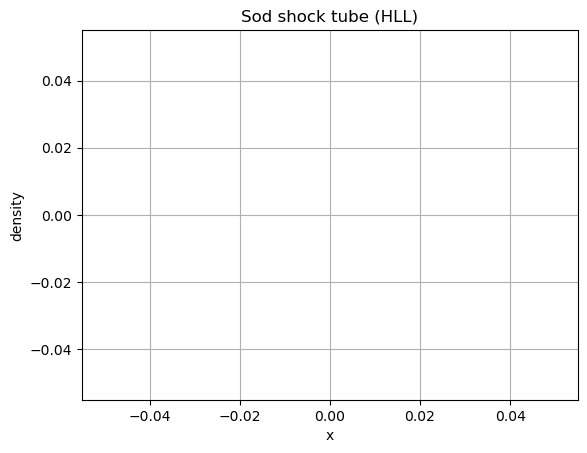

In [12]:
xp = x[ng:nx+ng]
rho = V[0, ng:nx+ng]
u   = V[1, ng:nx+ng]
p   = V[4, ng:nx+ng]

plt.figure()
plt.plot(xp, rho)
plt.xlabel("x"); plt.ylabel("density")
plt.title("Sod shock tube (HLL)")
plt.grid(True)

In [ ]:


def HLL_Method(V,nx,ng):

    V = outgoing(V, nx, ng)


    VL, VR = reconstruct_V(V,nx,ng)
    UL, UR = U_conserved_variable(VL), U_conserved_variable(VR) 

    for i in range(ng-1,nx+ng):

        vxL, pL, rhoL = VL[1,i], VL[4,i], VL[0,i]
        vxR, pR, rhoR = VR[1,i], VR[4,i], VR[0,i]

        EL, ER = UL[4,i], UR[4,i]

        HL = (EL + pL)/rhoL
        HR = (ER + pR)/rhoR
    
        roe_V = (np.sqrt(rhoL)*vxL + np.sqrt(rhoR)*vxR) / (np.sqrt(rhoL)+np.sqrt(rhoR))
        roe_H = (np.sqrt(rhoL)*HL + np.sqrt(rhoR)*HR) / (np.sqrt(rhoL)+np.sqrt(rhoR))
        roe_a = np.sqrt((gamma-1)*(roe_H - 0.5*roe_V**2))

        cL = np.sqrt(gamma*pL/rhoL)
        cR = np.sqrt(gamma*pR/rhoR)


        SL = min(vxL - cL, vxR - cR, roe_V - roe_a)
        SR = max(vxL + cL, vxR + cR, roe_V + roe_a)

        FL = Flux(VL[:,i])
        FR = Flux(VR[:,i])

        # print(FR)
        if SL >= 0 :
            F[:,i] = FL 
        elif SR <= 0 :
            F[:,i] = FR 
        else :
            F[:,i] = (SR*FL - SL*FR + SL*SR*(UR[:,i]-UL[:,i]))/(SR-SL)
    return F

In [ ]:
from multiprocessing.sharedctypes import Value
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy import linalg

gamma = 1.4



def conserved_variables(N,rho,vx,vy,vz,p):
    U = np.zeros((5,N))
    U[0,:] = rho 
    U[1,:] = rho * vx # x 축
    U[2,:] = rho * vy # y 축
    U[3,:] = rho * vz # y 축
    kinematics = 0.5*rho*(vx**2+vy**2+vz**2)
    U[4,:] = p/(gamma-1) + kinematics  # using ideal gas
    return U

def primitive_variables(U):
    rho = U[0]
    vx = U[1]/rho
    vy  = U[2]/rho
    vz = U[3]/rho
    p = (gamma - 1)*(U[4]-0.5*rho*(vx**2+vy**2+vz**2))  # ideal gas 

    return np.array([rho,vx,vy,vz,p])

# def primitive_variables(U):
#     Nloc = U.shape[1]
#     V = np.zeros((5,N))
#     V[0] = U[0]
#     V[1] = U[1]/V[0] 
#     V[2]  = U[2]/V[0] 
#     V[3] = U[3]/V[0]
#     V[4] = (gamma - 1)*(U[4]-0.5*V[0]*(V[1]**2+V[2]**2+V[3]**2))  # ideal gas 

#     return V

def Flux(V):
    rho, vx,vy,vz,p = V
    F = np.zeros(5)
    F[0] = rho*vx
    F[1] = rho*vx*vx + p
    F[2] = rho*vx*vy
    F[3] = rho*vx*vz
    kinematics = 0.5*rho*(vx**2+vy**2+vz**2)
    E = p/(gamma-1) + kinematics
    F[4] = (E + p)*vx # (U[4] + p) * u U[4] = E 
    return F


# def outgoing(V,nx,ng):

#     # V[:,:ng] = V[:,nx:nx+ng] # Periodic 
#     # V[:,nx+ng:] = V[:,ng:ng+ng] # Periodic
#     V[:,:ng] = V[:,ng] # outgoing
#     V[:,nx+ng:] = V[:,ng+nx-1] # outgoing
#     return V

def outgoing(V, nx, ng):
    V[:, :ng] = V[:, ng:ng+1]
    V[:, nx+ng:] = V[:, nx+ng-1:nx+ng]
    return V

def MC_RM(a,b,c): # the precise linear MC reconstruction method
    sign_a = np.sign(a) # -1 , 0 , 1 
    sign_b = np.sign(b) 
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a +sign_b)*min(abs(a),abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i +sign_c)*min(abs(s_i),abs(c))
    return   s_f 

def reconstruct_V(V,nx,ng):
    N = V.shape[1]
    VL = np.zeros((5, N))
    VR = np.zeros((5, N))

    dV = np.zeros((5, N)) #slope
    for k in range(5):
        for i in range(ng, nx+ng):
            a = (V[k, i]   - V[k, i-1]) 
            b = (V[k, i+1] - V[k, i])  
            c = (V[k, i+1] - V[k, i-1]) *0.5
            dV[k, i] = MC_RM(a, b, c)

    # interface states
    for k in range(5):
        for i in range(ng-1, nx+ng):  
            VL[k, i] = V[k, i] - 0.5*dV[k, i]
            VR[k, i] = V[k, i] + 0.5*dV[k, i]

    return VL, VR

# def Slope(U,nx,ng):
#     N = U.shape[1]
#     SL = np.zeros(N)
#     SR = np.zeros(N)

#     dS = np.zeros(N) #slope

#     # interface states

#     for i in range(ng-1, nx+ng):  
#         SL[i] = V[1, i] - 0.5*dV[k, i]
#         SR[i] = V[1, i] + 0.5*dV[k, i]

#     return VL, VR
    

x_min, x_max, nx = -1,1,400
dx = (x_max-x_min) / (nx)
x0 = 0.0
ng= 2 
N = nx + 2*ng

x = np.zeros(N)
for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx


v = 1.0
lam= 0.5
dt = lam*(dx/v)

Time = 0.0
Time_set = 0.2

rho_L, ux_L,uy_L,uz_L, P_L = 1.0, 0.0, 0.0, 0.0, 1.0
rho_R, ux_R,uy_R,uz_R,P_R = 0.125, 0.0, 0.0, 0.0, 0.1
# Step 1 : Define U,V + B.C  -------------------------------------------------

V = np.zeros((5, N))
for i in range(N):
    if x[i] < x0:
        V[:, i] = [rho_L, ux_L, uy_L, uz_L, P_L]
    else:
        V[:, i] = [rho_R, ux_R, uy_R, uz_R, P_R]


# V.shape
U = conserved_variables(N, V[0], V[1], V[2], V[3], V[4])
V = outgoing(V, nx, ng)

# Step 2 : Reconstruction  -------------------------------------------------
VL, VR = reconstruct_V(V,nx,ng)

# VL
UL = conserved_variables(N,VL[0],VL[1],VL[2],VL[3],VL[4])
UR = conserved_variables(N,VR[0],VR[1],VR[2],VR[3],VR[4])




# Roe average 

# VL[1,:]

# for i in range(ng-1,N-ng+1):
#     VL = primitive_variables(UL)[:,0]
#     VR = primitive_variables(UR)[:,0]
#     cL = np.sqrt(gamma*pL/rhoL)
#     cR = np.sqrt(gamma*pR/rhoR)

# VL
# F = np.zeros((5, N+1))  # interface flux

# VL[0]

# for i in range(ng-1,N-ng+1):

#     vxL, pL, rhoL = VL[1], VL[4], VL[0]
#     vxR, pR, rhoR = VR[1], VR[4], VR[0]
#     cL = np.sqrt(gamma*pL/rhoL)
#     cR = np.sqrt(gamma*pR/rhoR)

#     SL = min(vxL - cL, vxR - cR)
#     SR = max(vxL + cL, vxR + cR)

#     FL = Flux(VL)
#     FR = Flux(VR)

#     if SL >= 0 :
#         F[:,i] = FL 
#     elif SR <= 0 :
#         F[:,i] = FR 
#     else :
#         F[:,i] = (SR*FL - SL*FR + SL*SR*(UR-UL))/(SR-SL)

# F[1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

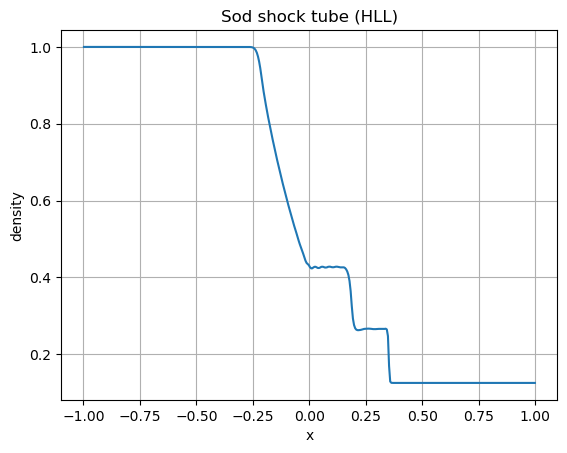

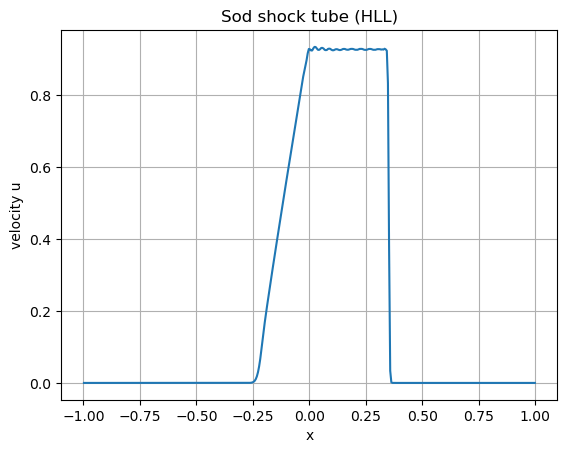

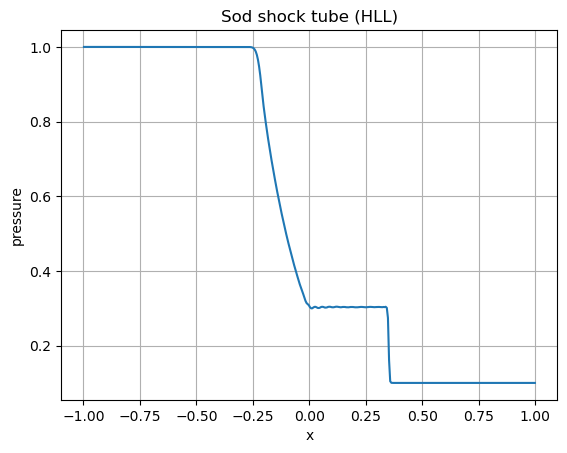

In [86]:
import numpy as np
import matplotlib.pyplot as plt

gamma = 1.4

def MC_RM(a, b, c):  # Monotonized Central limiter (scalar)
    sign_a = np.sign(a)
    sign_b = np.sign(b)
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a + sign_b) * min(abs(a), abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i + sign_c) * min(abs(s_i), abs(c))
    return s_f

def conserved_variables(N, rho, vx, vy, vz, p):
    U = np.zeros((5, N))
    U[0, :] = rho
    U[1, :] = rho * vx
    U[2, :] = rho * vy
    U[3, :] = rho * vz
    kinematics = 0.5 * rho * (vx**2 + vy**2 + vz**2)
    U[4, :] = p / (gamma - 1.0) + kinematics
    return U

def primitive_variables(U):
    # U shape: (5, N)
    Nloc = U.shape[1]
    V = np.zeros((5, Nloc))
    V[0] = U[0]
    V[1] = U[1] / V[0]
    V[2] = U[2] / V[0]
    V[3] = U[3] / V[0]
    V[4] = (gamma - 1.0) * (U[4] - 0.5 * V[0] * (V[1]**2 + V[2]**2 + V[3]**2))
    return V

def outflow(V, nx, ng):
    # Zerogradient / outflow BC
    # left ghosts = first interior
    V[:, :ng] = V[:, ng:ng+1]
    # right ghosts = last interior
    V[:, nx+ng:] = V[:, nx+ng-1:nx+ng]
    return V

def flux_from_primitive(V, U):
    # 1D flux in x-direction for 3D velocity components included in state
    rho = V[0]; u = V[1]; v = V[2]; w = V[3]; p = V[4]
    F = np.zeros(5)
    F[0] = rho * u
    F[1] = rho * u*u + p
    F[2] = rho * u*v
    F[3] = rho * u*w
    F[4] = (U[4] + p) * u
    return F

def sound_speed(V):
    return np.sqrt(gamma * V[4] / V[0])

def HLL_flux(UL, UR):
    # UL, UR shape: (5,)
    VL = primitive_variables(UL.reshape(5, 1))[:, 0]
    VR = primitive_variables(UR.reshape(5, 1))[:, 0]

    uL, uR = VL[1], VR[1]
    cL, cR = sound_speed(VL), sound_speed(VR)

    SL = min(uL - cL, uR - cR)
    SR = max(uL + cL, uR + cR)

    FL = flux_from_primitive(VL, UL)
    FR = flux_from_primitive(VR, UR)

    if SL >= 0.0:
        return FL
    elif SR <= 0.0:
        return FR
    else:
        return (SR*FL - SL*FR + SL*SR*(UR - UL)) / (SR - SL)

def reconstruct_MC(V, nx, ng):
    """
    MUSCL reconstruction with MC limiter (component-wise on primitive vars).
    Returns VL_face, VR_face at interfaces i+1/2 for i=ng-1..nx+ng-1
    We'll build arrays of size (5, N) for convenience:
      V_L[:, i] = left state at interface i+1/2
      V_R[:, i] = right state at interface i+1/2
    Only valid for i in [ng-1, nx+ng-1]
    """
    N = V.shape[1]
    V_L = np.zeros((5, N))
    V_R = np.zeros((5, N))

    # slopes on cell centers
    dV = np.zeros((5, N))
    for k in range(5):
        for i in range(ng, nx+ng):
            a = V[k, i]   - V[k, i-1]
            b = 0.5*(V[k, i+1] - V[k, i-1])
            c = V[k, i+1] - V[k, i]
            dV[k, i] = MC_RM(a, b, c)

    # interface states
    for k in range(5):
        for i in range(ng-1, nx+ng):  # interface i+1/2
            # left state from cell i
            V_L[k, i] = V[k, i] + 0.5*dV[k, i]
            # right state from cell i+1
            V_R[k, i] = V[k, i+1] - 0.5*dV[k, i+1]

    return V_L, V_R

def primitive_to_conserved(V):
    # V shape: (5,) -> U shape: (5,)
    rho, u, v, w, p = V
    U = np.zeros(5)
    U[0] = rho
    U[1] = rho*u
    U[2] = rho*v
    U[3] = rho*w
    E = p/(gamma-1.0) + 0.5*rho*(u*u + v*v + w*w)
    U[4] = E
    return U


# ------------------- Grid & parameters -------------------
x_min, x_max, nx = -1.0, 1.0, 400
dx = (x_max - x_min) / nx
x0 = 0.0

ng = 2
N = nx + 2*ng

x = np.zeros(N)
for i in range(N):
    x[i] = x_min + (i - ng + 0.5) * dx

lam = 0.5  # CFL
Time = 0.0
Time_set = 0.2

# Sod IC
rho_L, ux_L, uy_L, uz_L, P_L = 1.0,   0.0, 0.0, 0.0, 1.0
rho_R, ux_R, uy_R, uz_R, P_R = 0.125, 0.0, 0.0, 0.0, 0.1

# ------------------- Initialize primitive V(x) -------------------
V = np.zeros((5, N))
for i in range(N):
    if x[i] < x0:
        V[:, i] = [rho_L, ux_L, uy_L, uz_L, P_L]
    else:
        V[:, i] = [rho_R, ux_R, uy_R, uz_R, P_R]

# ------------------- Time integration -------------------
use_MUSCL_MC = True  # False면 1st-order Godunov(HLL)로 동작

while Time < Time_set:
    # BC
    V = outflow(V, nx, ng)

    # CFL dt (max |u|+c over interior)
    c = np.sqrt(gamma * V[4, ng:nx+ng] / V[0, ng:nx+ng])
    umax = np.max(np.abs(V[1, ng:nx+ng]) + c)
    dt = lam * dx / umax
    if Time + dt > Time_set:
        dt = Time_set - Time

    # cell-centered conserved
    U = conserved_variables(N, V[0], V[1], V[2], V[3], V[4])

    # interface fluxes
    F = np.zeros((5, N))  # store flux at interface i+1/2 in column i (for i=ng-1..nx+ng-1)

    if use_MUSCL_MC:
        V_L, V_R = reconstruct_MC(V, nx, ng)
        for i in range(ng-1, nx+ng):  # interface i+1/2
            UL = primitive_to_conserved(V_L[:, i])
            UR = primitive_to_conserved(V_R[:, i])
            F[:, i] = HLL_flux(UL, UR)
    else:
        for i in range(ng-1, nx+ng):  # interface i+1/2
            UL = U[:, i]
            UR = U[:, i+1]
            F[:, i] = HLL_flux(UL, UR)

    # Update U in interior cells
    U_new = U.copy()
    for i in range(ng, nx+ng):
        U_new[:, i] = U[:, i] - (dt/dx) * (F[:, i] - F[:, i-1])

    # Convert back to primitive
    V = primitive_variables(U_new)

    Time += dt

# ------------------- Plot -------------------
# plot only physical cells
xp = x[ng:nx+ng]
rho = V[0, ng:nx+ng]
u   = V[1, ng:nx+ng]
p   = V[4, ng:nx+ng]

plt.figure()
plt.plot(xp, rho)
plt.xlabel("x"); plt.ylabel("density")
plt.title("Sod shock tube (HLL)")
plt.grid(True)

plt.figure()
plt.plot(xp, u)
plt.xlabel("x"); plt.ylabel("velocity u")
plt.title("Sod shock tube (HLL)")
plt.grid(True)

plt.figure()
plt.plot(xp, p)
plt.xlabel("x"); plt.ylabel("pressure")
plt.title("Sod shock tube (HLL)")
plt.grid(True)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy import linalg

gamma = 1.4


def MC_RM(a,b,c): # the precise linear MC reconstruction method
    sign_a = np.sign(a) # -1 , 0 , 1 
    sign_b = np.sign(b) 
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a +sign_b)*min(abs(a),abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i +sign_c)*min(abs(s_i),abs(c))
    return   s_f 



def conserved_variables(rho,v,p):
    n = rho.size 
    U = np.zeros((5,n))
    U[0,:] = rho 
    U[1,:] = rho * v[0] # x 축
    U[2,:] = rho * v[1] # y 축
    U[3,:] = rho * v[2] # y 축
    kinematics = 0.5*rho*(v[0]**2+v[1]**2+v[2]**2)
    U[4,:] = p/(gamma-1) + kinematics  # using ideal gas
    return U


def primitive_variables(U):
    rho = U[0]
    v_x = U[1]/rho 
    v_y = U[2]/rho 
    v_z = U[3]/rho
    p = (gamma - 1)*(U[4]-0.5*rho*(v_x**2+v_y**2+v_z**2))  # ideal gas 
    return rho, v_x,v_y,v_z,p

def flux(U):
    rho,v_x,v_y,v_z,p = primitive_variables(U)
    n = rho.size 
    F = np.zeros((5,n))
    F[0,:] = rho*v_x 
    F[1,:] = rho*v_x*v_x + p 
    F[2,:] = rho*v_x*v_y 
    F[3,:]= rho*v_x*v_z 
    E = U[4]
    F[4,:] = v_x*(E+p)
    return F


def periodic(U,nx,ng):

    U[:,:ng] = U[:,nx:nx+ng] # Periodic 
    U[:,nx+ng:] = U[:,ng:ng+ng] # Periodic
    # q[:ng] = q[ng] # ongoing
    # q[nx+ng:] = q[ng+nx-1] # ongoing
    return U



def riemann_flux(UL, UR,vx):

    n = UL.size
    FL = flux(UL)
    FR = flux(UR)
    UL = UL.reshape(n,1)
    UR = UR.reshape(n,1)
    return 0.5* ((FL+FR) - vx*(UR-UL))

def PC_Method_U(U,nx,ng,dx,dt,vx):

    U = periodic(U,nx,ng)

    N = nx+2*ng 
    UL = np.zeros((5, N))
    UR = np.zeros((5, N))
    F_half =np.zeros((5, N+1))
    U_new =np.zeros((5, N))

    for i in range(ng-1,N-ng+1):
        
        for k in range(5):
            sL = (U[k,i] - U[k,i-1]) /(dx) 
            sR = (U[k,i+1] - U[k,i]) /(dx) 
            sC = (U[k,i+1] - U[k,i-1]) /(2*dx) 
            
            s_i = MC_RM(sL*2,sR*2,sC) 
            dqdt = -vx*s_i 

            UL[k,i] = U[k,i] - s_i*(dx)*0.5 + dt*0.5*(dqdt)
            UR[k,i] = U[k,i] + s_i*(dx)*0.5 + dt*0.5*(dqdt)
    for i in range(ng,N-ng+1):
        F_half[:,i] = riemann_flux(UR[:,i-1], UL[:,i],vx).squeeze()
           
    for i in range(ng,N-ng+1):
        U_new[:,i] = U[:,i] - (F_half[:,i+1]-F_half[:,i])/dx * dt

    return U_new


x_min, x_max, nx = -1,1,400
dx = (x_max-x_min) / (nx)
x0 = 0.0
ng= 2 
N = nx + 2*ng

v = 1.0
Time_set = 2.0
lam= 0.2
sig = 0.1
dt = lam*(dx/v)
A = 1.0
Time = 0.0

x = np.zeros(N)

for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx

rho = A * np.exp(-(x-x0)**2/sig**2)
vx= 1.0
vy = 3.0
vz= 5.0
v = np.array([vx,vy,vz])

p = 1.0

U = conserved_variables(rho,v,p)

Time_set = dt*6
while Time < Time_set:
    if Time + dt > Time_set:   
        dt = Time_set - Time   # For Time == Time_set 

    U =  PC_Method_U(U,nx,ng,dx,dt,vx)
   
    Time += dt 


In [26]:
U

array([[ 0.00000000e+00,  0.00000000e+00,  7.01093312e-44, ...,
         1.50710336e-43,  9.91057358e-44,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.57089732e-01, ...,
        -1.79868124e-02,  4.68280184e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.10327993e-43, ...,
         4.52131008e-43,  2.97317207e-43,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  3.50546656e-43, ...,
         7.53551681e-43,  4.95528679e-43,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.88092372e+00, ...,
         1.92882155e+00,  3.59166734e+00,  0.00000000e+00]])